In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

from extra_data import open_run
from extra_geom import JUNGFRAUGeometry
from data_utils import (load_trains, load_trains_pool, create_mask_assembled, create_mask_stacked,
                        create_whitefield, calculate_snr)
from streak_finder.src import robust_lsq

## Creating a json config file

I use JSON files to save the config data used in loading the data. A configuration file contains the following information:

- `data_type` : Choose between 'raw' and 'proc'.
- `geom_path` : A path to the JUNGFRAU geometry ('.geom') file.
- `modules` : Number of detector modules to load.
- `pattern` : Regex to find the module number in source names. Should contain a group
  which can be converted to an integer. E.g. ``r'/DET/JNGFR(\\d+)'`` for
  one JUNGFRAU naming convention.
- `sources` : glob patterns to select the JUNGFRAU detector sources.
- `starts_at` : By default, uses module numbers starting at 0 (e.g. 0-15 inclusive).
  If the numbering is e.g. 1-16 instead, pass ``starts_at = 1``.

In [15]:
PROPOSAL = 4456
DATA_TYPE = 'proc'
SOURCES = (('SPB_IRDA_JF4M/DET/JNGFR*:daqOutput', 'data.adc'),
           ('SPB_IRDA_JF4M/DET/JNGFR*:daqOutput', 'data.gain'),
           ('SPB_IRDA_JF4M/DET/JNGFR*:daqOutput', 'data.mask'))
PATTERN = r'SPB_IRDA_JF4M/DET/JNGFR(\d+)'
START_INDEX = 1
N_MODULES = 8
GEOM_PATH = '/gpfs/exfel/exp/SPB/202302/p004456/usr/geometry/geom_v5.geom'

CONFIG = {'proposal': PROPOSAL,
          'data_type': DATA_TYPE,
          'sources': SOURCES,
          'starts_at': START_INDEX,
          'modules': N_MODULES,
          'pattern': PATTERN,
          'geom_path': GEOM_PATH}

config = json.JSONDecoder().decode(json.dumps(CONFIG))

with open('test.json', 'w') as file:
    json.dump(config, file, sort_keys=True, ensure_ascii=False, indent=4)

In [2]:
# I've attached two config files: default.json and adc_only.json
# - default.json : Load data.adc, data.gain, and data.mask
# - adc_only.json : Load data.adc only

with open('adc_only.json', 'r') as file:
    config = json.load(file)

## Loading data

In [6]:
# Select run number
run_num = 56

# Open run with extra_data
run = open_run(proposal=config['proposal'], run=run_num, data=config['data_type'])
sel = run.select(config['sources'])

# Select a list of trains to load, you need to parse train_ids to load_trains
trains = sel.train_ids[::10]

# Load trains
data = load_trains(sel, trains, config, assembled=False)

Reading run:   0%|          | 0/73 [00:00<?, ?it/s]

In [6]:
# OR load trains concurrently (will work faster ONLY when the ammount of data
# loaded is comparatively low)
data = load_trains_pool(sel, trains, config, assembled=False, processes=4)

Reading run:   0%|          | 0/100 [00:00<?, ?it/s]

## Creating masks and white-fields

In [7]:
stacked = data['stacked']['data.adc']

stacked.min(), stacked.max()

(-15141.545, 128819.27)

In [8]:
# Creating a mask for stacked array

stacked = data['stacked']['data.adc']
mask = create_mask_stacked(stacked, vmin=0.0, vmax=5e2, std_max=1e4)

In [9]:
# Generating frames

geom = JUNGFRAUGeometry.from_crystfel_geom(config['geom_path'])
frames = np.nan_to_num(geom.position_modules(stacked * mask)[0], 0.0)
frames = np.clip(frames, 0.0, np.inf)

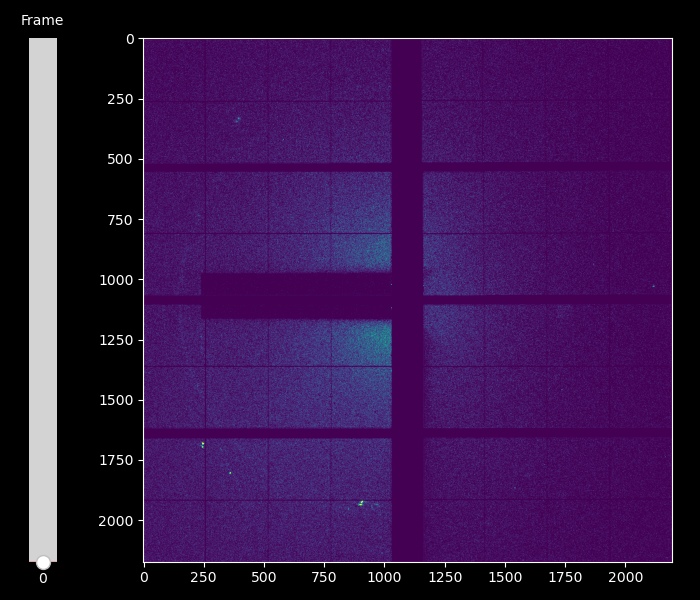

In [10]:
%matplotlib widget
fig, ax = plt.subplots(1, 2, figsize=(7, 6), gridspec_kw={'width_ratios': [0.1, 1.0]})

slider = Slider(ax=ax[0], label='Frame', valmin=0, valmax=frames.shape[0],
                valstep=np.arange(0, frames.shape[0]),
                valinit=0, orientation="vertical")

im = ax[1].imshow(frames[0], vmin=0.0, vmax=50.0)

def update(val):
    im.set_data(frames[slider.val])
    fig.canvas.draw_idle()

slider.on_changed(update)

fig.tight_layout()
plt.show()

In [11]:
# Generating a white-field

whitefield = create_whitefield(frames, num_threads=64)

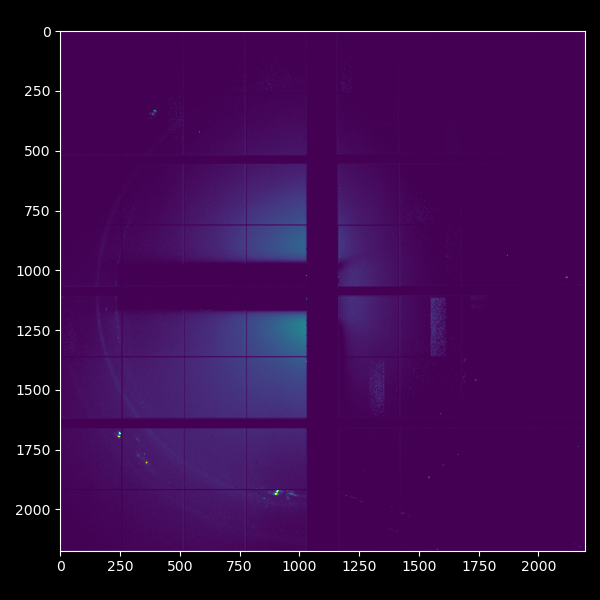

In [88]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(whitefield, vmin=0, vmax=50)

fig.tight_layout()
plt.show()

## Finding streaks

To find streaks one needs to follow the steps below:
1. Load data and masks.
2. Create a white-field and generate signal-to-noise frames as follows: $SNR = \frac{I - WF}{\sqrt{WF}}$.
3. Use *find_streaks* from *streak_finder*.

In [72]:
snr_frames = calculate_snr(frames, whitefield, num_threads=64)

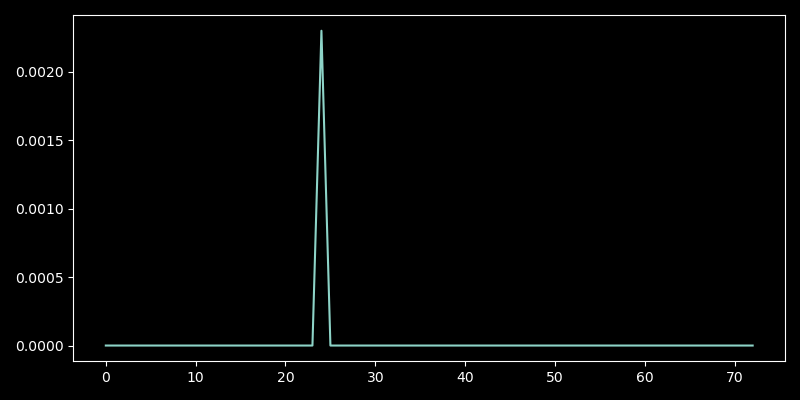

In [74]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8, 4))
# ax.plot(x[:, 0])
ax.plot(np.median(snr_frames, axis=(1, 2)))
fig.tight_layout()
plt.show()

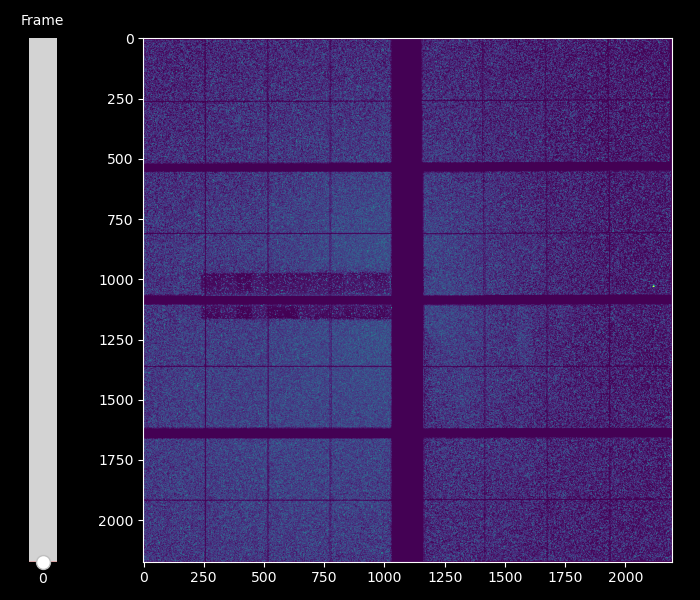

In [70]:
%matplotlib widget
fig, ax = plt.subplots(1, 2, figsize=(7, 6), gridspec_kw={'width_ratios': [0.1, 1.0]})

slider = Slider(ax=ax[0], label='Frame', valmin=0, valmax=snr_frames.shape[0],
                valstep=np.arange(0, snr_frames.shape[0]),
                valinit=0, orientation="vertical")

im = ax[1].imshow(snr_frames[0], vmin=0.0, vmax=3.0)

def update(val):
    im.set_data(snr_frames[slider.val])
    fig.canvas.draw_idle()

slider.on_changed(update)

fig.tight_layout()
plt.show()